# mesoSPIM PSF-analysis

Currently, this analysis notebook needs a stack with beads converted to `.tif`-files. pixel-size and zoom have to be set manually.

### Setup environment

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread, find_available_plugins
import time

In [2]:
from psf import plotPSF, getCenters, getPSF

### Setup plotting

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

In [4]:
from ipywidgets import interact
from ipywidgets import IntSlider

### Define parameters

`windowUm = [12, 10, 10]` defines a "window" volume in microns in which only a single bead can exist (for the bead to be included in the analysis, the volume has to contain a single bright maximum).

In [5]:
# Full FOV 
MAG = 2 # Mitu 2X 
TL_f_mm = 180 # Olympus TL
eff_MAG = MAG * TL_f_mm/200
UmPerPxLat = 4.25/eff_MAG
pxPerUmLat = 1/UmPerPxLat
pxPerUmAx = 1.0 # between z-planes
windowUm = [15, 15, 15] # 
options = {'pxPerUmLat':pxPerUmLat, 'pxPerUmAx':pxPerUmAx, 'windowUm':windowUm}
options['thresh'] = 700 #changed to abs, was relative: (0.05) 
options

{'pxPerUmLat': 0.4235294117647059,
 'pxPerUmAx': 1.0,
 'windowUm': [15, 15, 15],
 'thresh': 700}

In [6]:
datafolder = "D:\\benchtopData\\PSF\\"
LENS_NAME = f"Mitutoyo BD {MAG}x/0.14 TLf{TL_f_mm}"
CAMERA = "Photometrics Iris 15"
sensor_dim_mm = (21.49, 12.61) # Iris 15
freq_Hz = 99.9
exp_ms = 20
experiment_key = f"{MAG}scanned" #should start with magnification. e.g. 2
datafiles = {
    f"{MAG}scanned": datafolder + f"2022-09-20-Fbright200um-2XMitutoy-TL_Olympus\\488-2X_Mitu(TL-Olympus)-scanned.tif",
    f"{MAG}nonscanned": datafolder + f"2022-09-20-Fbright200um-2XMitutoy-TL_Olympus\\488-2X_Mitu(TL-Olympus)-nonscanned.tif",
    f"{MAG}test-center": datafolder + f"2022-09-20-Fbright200um-2XMitutoy-TL_Olympus\\test-mini-stack-scanned-1.tif",
    f"{MAG}test-corner": datafolder + f"2022-09-20-Fbright200um-2XMitutoy-TL_Olympus\\test-mini-stack-scanned-2.tif",
}


### Load data

In [7]:
im = imread(datafiles[experiment_key], plugin='tifffile')[:20]
im.shape

(20, 5056, 2960)

### Computation

In [8]:
start_time = time.time()
beads, maxima, centers, smoothed = getCenters(im, options)
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

findBeads() done: 20971 found
centersM done
centerDists done
keepBeads() done: 7083 found
getCenters() done: 7083 found
Runtime:  49.50409483909607  s


In [9]:
start_time = time.time()
data = [getPSF(x, options) for x in beads]
stop_time = time.time()
print('Runtime: ',stop_time-start_time, ' s')

Runtime:  12.645172834396362  s


In [10]:
centers = pd.DataFrame(centers, columns=['Z','Y','X'])

In [11]:
PSF = pd.concat([x[0] for x in data])
PSF['Max'] = maxima
PSF = PSF.reset_index().drop(['index'],axis=1)
latProfile = [x[1] for x in data]
axProfile = [x[2] for x in data]
PSF = PSF.join(centers)

### Inspect results

In [12]:
PSF.head()

,FWHMlat,FWHMax,Max,Z,Y,X
0,5.526241,3.978790,3819,12,4921,971
1,6.195817,5.362386,3623,10,4974,1763
2,5.769815,7.680477,3280,10,5012,2116
3,6.701386,4.859190,2885,13,551,79
4,6.734957,4.337000,2886,8,713,88


In [13]:
print('# Beads: ', len(PSF))
print('Median lateral FWHM (+/- std): ', round(np.median(PSF['FWHMlat']),2), ' +/- ', round(PSF['FWHMlat'].std(),2), ' μm')
print(f"MIN, MAX lateral FWHM: , {round(PSF['FWHMlat'].min(),2)}, {round(PSF['FWHMlat'].max(),2)} μm")
print('Median axial FWHM  (+/- std): ', round(np.median(PSF['FWHMax']),2), ' +/- ', round(PSF['FWHMax'].std(),2), ' μm')
print(f"MIN, MAX axial FWHM: {round(PSF['FWHMax'].min(),2)}, {round(PSF['FWHMax'].max(),2)}, μm")

print('Watch for large STD (>2 um), they indicate bad detections, e.g. multiple beads merged together.')

# Beads:  7083
Median lateral FWHM (+/- std):  5.12  +/-  23.04  μm
MIN, MAX lateral FWHM: , -1027.62, 826.95 μm
Median axial FWHM  (+/- std):  5.17  +/-  27.21  μm
MIN, MAX axial FWHM: 2.2, 936.6, μm
Watch for large STD (>2 um), they indicate bad detections, e.g. multiple beads merged together.


### Plot axial FWHM vs. FOV

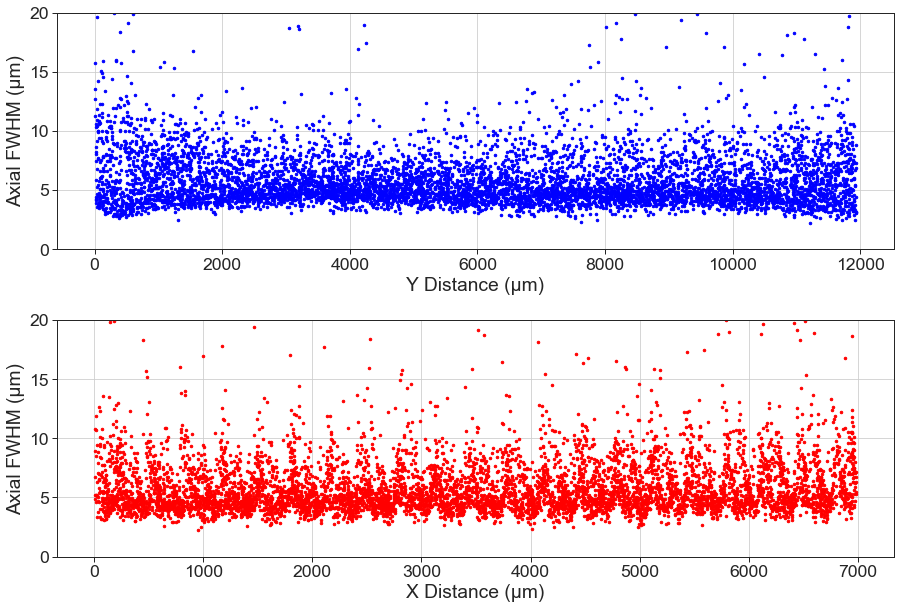

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(15,10));

subfigure0 = fig.add_subplot(211)
subfigure0.plot(np.multiply(PSF['Y'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.b',ms=5)
subfigure0.set_ylim([0,20])
subfigure0.set_xlabel('Y Distance (μm)')
subfigure0.set_ylabel('Axial FWHM (μm)')
subfigure0.grid()

subfigure1 = fig.add_subplot(212)
subfigure1.plot(np.multiply(PSF['X'].tolist(),UmPerPxLat),PSF['FWHMax'].tolist(),'.r',ms=5)
subfigure1.set_ylim([0,20])
subfigure1.set_xlabel('X Distance (μm)')
subfigure1.set_ylabel('Axial FWHM (μm)')
subfigure1.grid()

plt.subplots_adjust(hspace = 0.3)

## Todo: why is there more detections at Y axis edges? Brighter light-sheet?

### Save data and plots

In [22]:
PSF.to_csv(datafolder + '/withETL-20ms-99hz-2x.csv')

In [24]:
fig.savefig(datafolder + f'/withETL-{exp_ms}ms-{freq_Hz}hz-2x-Comparision.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/withETL-{exp_ms}ms-{freq_Hz}hz-2x-Comparision.jpg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

## Sanity checks

### Plot max projection and detected beads

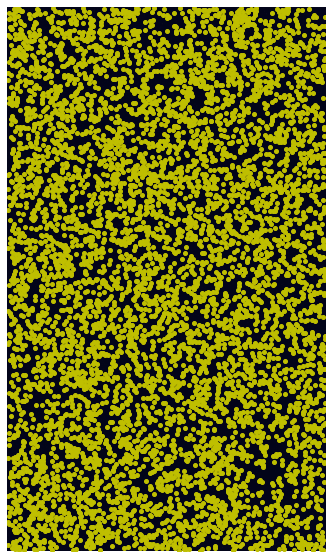

In [25]:
plt.figure(figsize=(10,10));
plt.imshow(smoothed);
plt.plot(PSF['X'].tolist(), PSF['Y'].tolist(), 'y.', ms=8);
plt.axis('off'); 

### Axial and lateral FWHM Histogram

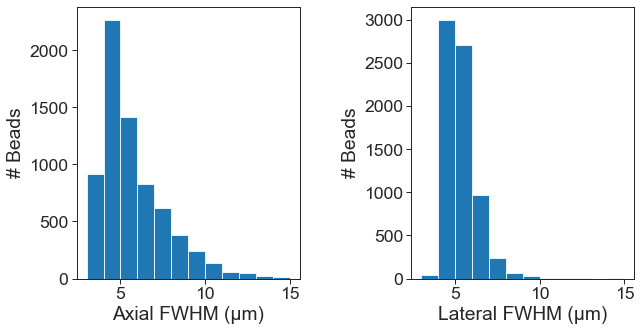

In [26]:
fig = plt.figure(figsize=(10,5))
subfigure0 = fig.add_subplot(121)
subfigure0.hist(PSF['FWHMax'].tolist(),12,range=(3,15))
subfigure0.set_xlabel('Axial FWHM (μm)')
subfigure0.set_ylabel('# Beads')
subfigure1 = fig.add_subplot(122)
subfigure1.hist(PSF['FWHMlat'].tolist(),12,range=(3,15))
subfigure1.set_xlabel('Lateral FWHM (μm)')
subfigure1.set_ylabel('# Beads')

plt.subplots_adjust(wspace = 0.5)

### Overview Plots

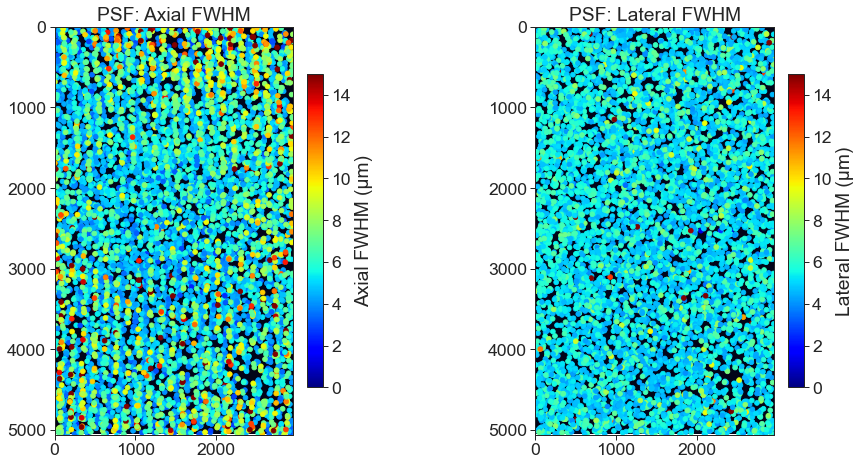

In [46]:
fig = plt.figure(figsize=(15,7.5));
cmap = 'jet'

subfigure0 = fig.add_subplot(121)
subfigure0.imshow(smoothed)
overlay0 = subfigure0.scatter(PSF['X'].tolist(), PSF['Y'].tolist(), c=PSF['FWHMax'].tolist(), cmap=cmap, vmin=0, vmax=15)
subfigure0.axis('on');
subfigure0.set_title('PSF: Axial FWHM')
cbar0 = plt.colorbar(overlay0,fraction=0.044, pad=0.04)
cbar0.set_label('Axial FWHM (μm)')


subfigure1 = fig.add_subplot(122)
subfigure1.imshow(smoothed);
overlay1 = subfigure1.scatter(PSF['X'].tolist(), PSF['Y'].tolist(), c=PSF['FWHMlat'].tolist(), cmap=cmap, vmin=0, vmax=15);
subfigure1.axis('on');
subfigure1.set_title('PSF: Lateral FWHM')
cbar1 = plt.colorbar(overlay1,fraction=0.044, pad=0.04)
cbar1.set_label('Lateral FWHM (μm)')

plt.subplots_adjust(wspace = 0.35)

In [44]:
fig.savefig(datafolder + f'/withETL-{exp_ms}ms-{freq_Hz}hz-2x-Comparision-XYplot-improved-colors.svg', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)
fig.savefig(datafolder + f'/withETL-{exp_ms}ms-{freq_Hz}hz-2x-Comparision-XYplot-improved-colors.png', facecolor=fig.get_facecolor(), edgecolor='none',dpi=200)

### Plot XYZ projections of selected PSFs and fit

In [35]:
centerPSFs = PSF[PSF.FWHMlat > 10]
centerPSFs.head()

,FWHMlat,FWHMax,Max,Z,Y,X
33,10.511714,4.731104,1979,12,4833,800
36,42.427445,4.630631,2593,8,3519,292
109,720.710784,5.550479,1865,7,4947,2383
135,522.095697,5.715128,1821,11,4870,502
161,27.481600,3.315899,1889,11,4779,1655


In [36]:
len(centerPSFs)

33

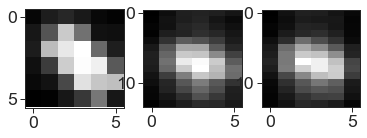

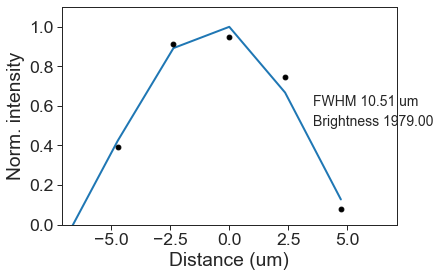

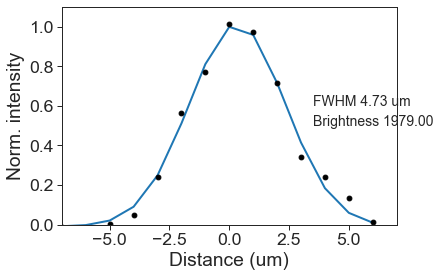

In [37]:
# Plot PSF with known ID
beadInd = 33
average = beads[beadInd]

fig, _axs = plt.subplots(nrows=1, ncols=3)
axs = _axs.flatten()

XYview = axs[0].imshow(average.mean(axis=0), cmap='gray');
XZview = axs[1].imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
YZview = axs[2].imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx, cmap='gray');
plt.show()

plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
plt.show()
plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
plt.show()

In [82]:
fig = plt.figure()

def update(w = 50):
    beadInd = w
    average = beads[beadInd]
    
    fig, _axs = plt.subplots(nrows=1, ncols=3)
    axs = _axs.flatten()

    XYview = axs[0].imshow(average.mean(axis=0));
    XZview = axs[1].imshow(average.mean(axis=1), aspect = pxPerUmLat/pxPerUmAx);
    YZview = axs[2].imshow(average.mean(axis=2), aspect = pxPerUmLat/pxPerUmAx);
    plt.show()
    plotPSF(latProfile[beadInd][0],latProfile[beadInd][1],latProfile[beadInd][2],latProfile[beadInd][3],pxPerUmLat,PSF.Max.iloc[beadInd])
    plt.show()
    plotPSF(axProfile[beadInd][0],axProfile[beadInd][1],axProfile[beadInd][2],axProfile[beadInd][3],pxPerUmAx,PSF.Max.iloc[beadInd])
    plt.show()

interact(update, w=IntSlider(min=0,max=len(PSF)-1,step=1,value=0,continuous_update=False));

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=0, continuous_update=False, description='w', max=648), Output()), _dom_c…